<a href="https://colab.research.google.com/github/teticio/aventuras-con-textos/blob/master/Atenci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Attention = Atención

[Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/pdf/1409.0473.pdf)

### Importar las librerías

In [0]:
import re
import os
import random
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical, get_file
from keras.engine import Layer
from keras.layers import Input, LSTM, Dense, TimeDistributed
from keras.layers import Embedding, Concatenate, Dropout
from keras.models import Model
from keras import initializers
import keras.backend as K

### Conectar con Google Drive

In [0]:
checkpoint_dir = 'checkpoints'

try: # estamos en Google Colab?
    from google.colab import drive
    drive.mount('/content/drive')
    checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/checkpoints'
except:
    pass

try: # crear directorio para los checkpoints (si no exista ya)
    os.makedirs(checkpoint_dir)
except FileExistsError:
    pass

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Podemos usar un conjunto de datos con un vocabulario muy limitado para facilitar el entrenamiento...

In [0]:
path_en = get_file('small_vocab_en', origin='https://raw.githubusercontent.com/udacity/deep-learning/master/language-translation/data/small_vocab_en')
path_fr = get_file('small_vocab_fr', origin='https://raw.githubusercontent.com/udacity/deep-learning/master/language-translation/data/small_vocab_fr')

with open(path_en, 'rt', encoding='utf-8') as file:
    native = [line[:-1] for line in file.readlines()]
with open(path_fr, 'rt', encoding='utf-8') as file:
    foreign = [line[:-1] for line in file.readlines()]

10141696/10135742 [==============================] - 0s 0us/step


### ...o un conjunto de datos más interesante

In [0]:
# puedes encontrar otros texto paralelos aquí
# cuidado porque se actualizan periodicamente
# https://www.manythings.org/anki/

path_to_zip = get_file('spa-eng.zip',
                       origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
                       extract=True)
path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

native = []
foreign = []
with open(path_to_file, 'rt', encoding='utf-8') as file:
    for line in file.readlines():
        tab = line.find('\t')
        native += [line[:tab]]
        foreign += [line[tab+1:-1]]

In [0]:
native[123], foreign[123]

('Help me!', 'Ayúdame.')

In [0]:
foreign = ['[SOS] ' + _ + ' [EOS]' for _ in foreign]

### Añadir los tokens que marcan el comienzo ("[SOS]") y el final ("[EOS]") de cada frase

¡Tal vez "[SOS]" no es una buena elección porque "sos" quiere decir "eres" en argentina...!

In [0]:
native[123], foreign[123]

('Help me!', '[SOS] Ayúdame. [EOS]')

### Tokenizar

In [0]:
max_words = 100000 #@param {type : 'number'}

native_tokenizer = Tokenizer(num_words = max_words, oov_token='[UNK]')
native_tokenizer.fit_on_texts(native)
native_index2word = dict(zip(native_tokenizer.word_index.values(), native_tokenizer.word_index.keys()))
native = native_tokenizer.texts_to_sequences(native)
native_vocab_size = min(max_words, len(native_tokenizer.index_word.keys()) + 1) # pad = 0

foreign_tokenizer = Tokenizer(num_words = max_words, oov_token='[UNK]')
foreign_tokenizer.fit_on_texts(foreign)
foreign_index2word = dict(zip(foreign_tokenizer.word_index.values(), foreign_tokenizer.word_index.keys()))
foreign = foreign_tokenizer.texts_to_sequences(foreign)
foreign_vocab_size = min(max_words, len(foreign_tokenizer.index_word.keys()) + 1) # pad = 0

In [0]:
native_vocab_size, foreign_vocab_size

(13526, 26937)

In [0]:
native[123], foreign[123]

([87, 18], [2, 2340, 3])

In [0]:
[native_index2word.get(_, "") for _ in native[123]], [foreign_index2word.get(_, "") for _ in foreign[123]]

(['help', 'me'], ['sos', 'ayúdame', 'eos'])

### Hacer que las secuencias tienen el mismo tamaño

In [0]:
max_len = 20 #@param {type : 'number'}

native = sequence.pad_sequences(native, maxlen=max_len, padding='pre', truncating='post')
foreign = sequence.pad_sequences(foreign, maxlen=max_len, padding='post', truncating='post') # OJO

In [0]:
native[123], foreign[123]

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 87, 18], dtype=int32),
 array([   2, 2340,    3,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32))

### Seq2Seq para NMT (*Neural Machine Translation*)

![texto alternativo](https://miro.medium.com/max/1000/1*7Ki7jDc2f_fH1mHluoZKpA.jpeg)
https://towardsdatascience.com/word-level-english-to-marathi-neural-machine-translation-using-seq2seq-encoder-decoder-lstm-model-1a913f2dc4a7

### Capa de Keras para convertir los tokens a vectores one hot

In [0]:
class OneHot(Layer):
    def __init__(self, number_of_tokens, **kwargs):
        super(OneHot, self).__init__(**kwargs)
        self.number_of_tokens = number_of_tokens

    def call(self, inputs):
        if K.dtype(inputs) != 'int32':
            inputs = K.cast(inputs, 'int32')
        return K.one_hot(inputs, self.number_of_tokens)
    
    def compute_output_shape(self, input_shape):
        return input_shape + (self.number_of_tokens,)

### Generador para pasar los token objetivos a vectores one hot

In [0]:
def batch_generator(x, y, num_tokens, batch_size = 128):
    indices = np.random.permutation(len(y))
    i = 0
    while True:
        start = i * batch_size
        end = start + batch_size
        batch = indices[start:end]
        batch_X = [x[0][batch], x[1][batch]]
        batch_Y = to_categorical(y[batch], num_tokens)
        i = i + 1
        if end >= len(y):
            i = 0
        yield(batch_X, batch_Y)

### Crear el modelo: el *encoder*

In [0]:
num_hidden_units = 1024 #@param {type : 'number'}
embedding_dim = 256 #@param {type : 'number'}

encoder_inputs = Input(shape=(max_len,), name='encoder_inputs')
encoder_embedding = Embedding(native_vocab_size, embedding_dim, name='encoder_embedding')
encoder_in = encoder_embedding(encoder_inputs)
encoder_lstm = LSTM(num_hidden_units, return_state=True, return_sequences=True, name='encoder_lstm')
encoder_out, state_h, state_c = encoder_lstm(encoder_in) # utilizaremos los output en otro modelo más adelante
encoder_states = [state_h, state_c]

W0725 09:07:29.015170 140000194971520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 09:07:29.067633 140000194971520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 09:07:29.082922 140000194971520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



### el *decoder*

In [0]:
decoder_inputs = Input(shape=(max_len - 1,), name='decoder_inputs') # OJO: secuencia con [SOS] pero sin [EOS]
#decoder_embedding = OneHot(foreign_vocab_size)
decoder_embedding = Embedding(foreign_vocab_size, embedding_dim, name='decoder_embedding')
decoder_in = decoder_embedding(decoder_inputs)
decoder_lstm = LSTM(num_hidden_units, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_out, _, _ = decoder_lstm(decoder_in, initial_state=encoder_states)
decoder_dense = Dense(foreign_vocab_size, activation='softmax')
decoder_outputs = TimeDistributed(decoder_dense, name='decoder_dense')(decoder_out) # https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/

### y el modelo completo

In [0]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
print('FULL MODEL')
model.summary()

W0725 09:07:34.129701 140000194971520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0725 09:07:34.155077 140000194971520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



FULL MODEL
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, 20)           0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     (None, 19)           0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, 20, 256)      3462656     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, 19, 256)      6895872     decoder_inputs[0][0]             
__________________________________________________________________________________________________

### Entrenar el modelo

In [0]:
#model.load_weights(checkpoint_dir + '/Seq2SeqModel.h5')
batch_size = 512 #@param {type : 'number'}
model.fit_generator(batch_generator([native, foreign[:,:-1]], foreign[:, 1:], foreign_vocab_size, batch_size = batch_size),
                    steps_per_epoch=native.shape[0] // batch_size + 1,
                    epochs=25)

Epoch 1/25
233/233 [==============================] - 497s 2s/step - loss: 2.3704 - acc: 0.6754
Epoch 2/25
233/233 [==============================] - 491s 2s/step - loss: 1.7551 - acc: 0.7255
Epoch 3/25
233/233 [==============================] - 485s 2s/step - loss: 1.4752 - acc: 0.7539
Epoch 4/25
233/233 [==============================] - 486s 2s/step - loss: 1.2680 - acc: 0.7791
Epoch 5/25
233/233 [==============================] - 489s 2s/step - loss: 1.0965 - acc: 0.8012
Epoch 6/25
233/233 [==============================] - 484s 2s/step - loss: 0.9530 - acc: 0.8204
Epoch 7/25
233/233 [==============================] - 487s 2s/step - loss: 0.8309 - acc: 0.8385
Epoch 8/25
233/233 [==============================] - 487s 2s/step - loss: 0.7249 - acc: 0.8550
Epoch 9/25
233/233 [==============================] - 488s 2s/step - loss: 0.6318 - acc: 0.8707
Epoch 10/25
233/233 [==============================] - 485s 2s/step - loss: 0.5496 - acc: 0.8856
Epoch 11/25
233/233 [==================

In [0]:
model.save_weights(checkpoint_dir + '/Seq2SeqModel.h5')

In [0]:
model.load_weights(checkpoint_dir + '/Seq2SeqModel.h5')

### Visualizar los embedding

In [0]:
import pandas as pd
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

def plot_tsne(embedding_matrix, index_to_word, num_words = None, title = 't-SNE'):
    matrix = embedding_matrix
    if num_words is not None:
        matrix = matrix[:num_words,:]
    labels = [index_to_word.get(_, "<UNK>") for _ in range(matrix.shape[0])]
    
    # defining the chart
    output_notebook()
    fig = bp.figure(plot_width=700, plot_height=600, title=title,
                    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                    x_axis_type=None, y_axis_type=None, min_border=1)

    # dimensionality reduction. converting the vectors to 2d vectors
    from sklearn.manifold import TSNE
    tsne_model = TSNE(n_components=2, verbose=0, random_state=0)
    tsne_w2v = tsne_model.fit_transform(matrix)

    # putting everything in a dataframe
    tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
    tsne_df['words'] = labels

    # plotting. the corresponding word appears when you hover on the data point.
    fig.scatter(x='x', y='y', source=tsne_df)
    hover = fig.select(dict(type=HoverTool))
    hover.tooltips={"": "@words"}
    show(fig)

In [0]:
plot_tsne(encoder_embedding.get_weights()[0], native_index2word, title='English')

Loading BokehJS ...

In [0]:
plot_tsne(decoder_embedding.get_weights()[0], foreign_index2word, title='Spanish')

Loading BokehJS ...

### *Teacher Forcing*



``model_inputs = [native, foreign[:,:-1]], model_outputs = foreign[:, 1:]
``



In [0]:
for i in range(10):
    ind = random.randint(0, len(native))
    sentence = (' ').join([native_index2word.get(_,'') for _ in native[ind]])
    target_sentence = (' ').join([foreign_index2word.get(_,'') for _ in foreign[ind][1:]])
    seq = np.expand_dims(native[ind], axis=0) 

    # empieza bien, pero rápidamente pierde el hilo
    dec_inputs = np.zeros((1, max_len - 1))
    dec_inputs[0, 0] = foreign_tokenizer.word_index['sos']
    dec_outputs = model.predict([seq, dec_inputs])
    tokens = np.argmax(dec_outputs, axis=-1)[0]
    translated_sentence = ' '.join([foreign_index2word.get(_,'') for _ in tokens])
    
    # esto va mejor, pero es hacer "trampa"...
    dec_inputs = np.expand_dims(foreign[ind,:-1], axis=0)
    dec_outputs = model.predict([seq, dec_inputs])
    tokens = np.argmax(dec_outputs, axis=-1)[0]
    translated_sentence_with_teacher_forcing = ' '.join([foreign_index2word.get(_,'') for _ in tokens])

    print(sentence)
    print(translated_sentence)
    print(translated_sentence_with_teacher_forcing)
    print(target_sentence)
    print()

               why don't you trust me
¿por                  
¿por qué no confías usted confianza en mí eos          
¿por qué no tiene usted confianza en mí eos          

                did you love me
¿me                  
¿me querías eos                
¿me amabas eos                

       i've heard that you shouldn't eat red meat more than once a day
he                  
he oído que no deberías comer carne roja en de un vez al día eos    
he oído que no deberías comer carne roja más de una vez al día eos    

            i thought it was illegal to park here
pensé                  
pensé que era ilegal estacionarse aquí eos            
pensé que era ilegal estacionarse aquí eos            

         i know one thing we could do that might be fun
sé                  
sé que cosa que podríamos hacer que puede ser divertida eos        
sé una cosa que podríamos hacer que puede ser divertida eos        

            he got what he wanted against all odds
contra                  
co

![texto alternativo](https://miro.medium.com/max/700/1*xDPdW9nf7HdVDcBCQUJG7A.jpeg)

### Definir un encoder para hacer inferencia

In [0]:
encoder_inf_inputs = Input((max_len,), name='encoder_inf_inputs')
encoder_inf_in = encoder_embedding(encoder_inf_inputs)
encoder_inf_out, state_h, state_c = encoder_lstm(encoder_inf_in)
encoder_model = Model(inputs=encoder_inf_inputs, outputs=[encoder_inf_out, state_h, state_c])
print('ENCODER')
encoder_model.summary()

ENCODER
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inf_inputs (InputLay (None, 20)                0         
_________________________________________________________________
encoder_embedding (Embedding (None, 20, 256)           3462656   
_________________________________________________________________
encoder_lstm (LSTM)          [(None, 20, 1024), (None, 5246976   
Total params: 8,709,632
Trainable params: 8,709,632
Non-trainable params: 0
_________________________________________________________________


### y un decoder para hacer inferencia

In [0]:
decoder_init_states = [Input((num_hidden_units,), name='encoder_state_h'), Input((num_hidden_units,), name='encoder_state_c')]
encoder_inf_outputs = Input((max_len, num_hidden_units), name='encoder_inf_outputs')
decoder_inf_inputs = Input((1,), name='decoder_inf_inputs') # token por token
decoder_inf_in = decoder_embedding(decoder_inf_inputs)
decoder_inf_out, state_h, state_c = decoder_lstm(decoder_inf_in, initial_state=decoder_init_states)
decoder_inf_pred = TimeDistributed(decoder_dense, name='decoder_inf_dense')(decoder_inf_out)
decoder_model = Model(inputs=[encoder_inf_outputs] + decoder_init_states + [decoder_inf_inputs],
                      outputs=[decoder_inf_pred, state_h, state_c])
print('DECODER')
decoder_model.summary()

DECODER
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inf_inputs (InputLayer) (None, 1)            0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   multiple             6895872     decoder_inf_inputs[0][0]         
__________________________________________________________________________________________________
encoder_state_h (InputLayer)    (None, 1024)         0                                            
__________________________________________________________________________________________________
encoder_state_c (InputLayer)    (None, 1024)         0                                            
__________________________________________________________________________________________________
de

### *Greedy decoding*

In [0]:
frase_en_ingles = "Who did you go with to the movies?" #@param {type : 'string'}
seq = native_tokenizer.texts_to_sequences([frase_en_ingles])
seq = sequence.pad_sequences(seq, maxlen=max_len, padding='pre', truncating='post')
sentence = (' ').join([native_index2word.get(_,'') for _ in seq[0]])
print(sentence)

            who did you go with to the movies


In [0]:
enc_outputs, h, c = encoder_model.predict(seq)
dec_inputs = np.expand_dims(foreign_tokenizer.word_index['sos'], axis=0)
translated_sentence = ''
for i in range(max_len):
    dec_outputs, h, c = decoder_model.predict([enc_outputs, h, c, dec_inputs])
    token = np.argmax(dec_outputs, axis=-1)[0, 0]
    word = foreign_index2word.get(token, '')
    if word == '' or word == 'eos':
        break
    dec_inputs = np.expand_dims(token, axis=0)
    translated_sentence += word + ' '
print(translated_sentence)

¿a quién fuiste al cine 


### *Beam Search* (beam = haz luminoso)

En lugar de simplemente elegir la palabra más probable en cada paso según $P[x_i]$, queremos elegir la frase más probable. Para ello, usamos la red para calcular las probabilidades de cada palabra condicionada en la previa $P[x_i|x_{i-1}]$. Queremos la frase $x_0 x_1 ... x_n$ con mayor probabilidad $P[x_0] P[x_1|x_0] ...  P[x_n|x_{n-1}]$.

El número de probabilidades que tenemos que calcular en cada paso expande como una "haz luminoso": de allí el nombre del algoritmo [beam search](https://hackernoon.com/beam-search-a-search-strategy-5d92fb7817f). Limitamos la anchura de la haz en cada paso a las $k$ candidatos más probables.

En lugar de $P[x_0] P[x_1|x_0] ...  P[x_n|x_{n-1}]$ consideramos $\log P[x_0] + \log P[x_1|x_0] + ...  + \log P[x_n|x_{n-1}]$ para poder discriminar entre probabilidades muy pequeñas

In [0]:
k = 5
enc_outputs, h, c = encoder_model.predict(seq)
candidates = [('', 0, foreign_tokenizer.word_index['sos'])]
candidates # (frase_hasta_ahora, probabilidad de la última palabra condicionada en la previa, token de la última palabra)

[('', 0, 2)]

In [0]:
dec_inputs = np.array([[_[2]] for _ in candidates])
dec_outputs, h, c = decoder_model.predict([enc_outputs, h, c, dec_inputs])

In [0]:
top_k = [np.flip(dec_outputs[token, 0].argsort()[-k:]) for token in range(min(k, len(candidates)))]
top_k # los siguientes token más probables

[array([ 228, 1117,   53,  898,   80])]

In [0]:
next_candidates = [(candidates[token][0] + ' ' + foreign_index2word.get(top_k[token][next_token], ''), # frase hasta ahora
                    candidates[token][1] - np.log(dec_outputs[token, 0, top_k[token][next_token]]), # probabilidad de la última palabra condicionada en la previa
                    top_k[token][next_token]) # token de la última palabra
                   for next_token in range(k)
                   for token in range(len(top_k))]
candidates = sorted(next_candidates, key=lambda x:x[1])[:k]
candidates

[(' ¿a', 0.3855782449245453, 228),
 (' ¿con', 1.2279478311538696, 1117),
 (' ¿qué', 4.064363479614258, 53),
 (' ¿tú', 6.396353721618652, 898),
 (' ¿por', 6.5712127685546875, 80)]

In [0]:
# preparar batch para predicir las siguientes palabras condicionadas en estas
dec_inputs = np.array([[_[2]] for _ in candidates])
dec_inputs.shape, enc_outputs.shape, h.shape, c.shape

((5, 1), (1, 20, 1024), (1, 1024), (1, 1024))

In [0]:
# igualar los tamaños de los inputs al modelo
h = np.repeat(h, dec_inputs.shape[0]-h.shape[0]+1, axis=0)
c = np.repeat(c, dec_inputs.shape[0]-c.shape[0]+1, axis=0)
enc_outputs = np.repeat(enc_outputs, dec_inputs.shape[0]-enc_outputs.shape[0]+1, axis=0)
dec_inputs.shape, enc_outputs.shape, h.shape, c.shape

((5, 1), (5, 20, 1024), (5, 1024), (5, 1024))

In [0]:
# repetir para la siguiente palabra
dec_outputs, h, c = decoder_model.predict([enc_outputs, h, c, dec_inputs])
top_k = [np.flip(dec_outputs[token, 0].argsort()[-k:]) for token in range(min(k, len(candidates)))]
next_candidates = [(candidates[token][0] + ' ' + foreign_index2word.get(top_k[token][next_token], ''), # frase hasta ahora
                    candidates[token][1] - np.log(dec_outputs[token, 0, top_k[token][next_token]]), # probabilidad de la última palabra condicionada en la previa
                    top_k[token][next_token]) # token de la última palabra
                   for next_token in range(k)
                   for token in range(len(top_k))]
sorted(next_candidates, key=lambda x:x[1])

[(' ¿a quién', 0.47608374059200287, 194),
 (' ¿con quién', 1.3522792756557465, 194),
 (' ¿con ir', 3.4573718309402466, 64),
 (' ¿a qué', 3.735998958349228, 35),
 (' ¿a dónde', 4.092158168554306, 187),
 (' ¿a que', 4.348145097494125, 5),
 (' ¿qué vas', 4.715336918830872, 239),
 (' ¿qué fuiste', 5.134426832199097, 1481),
 (' ¿a ir', 5.400340169668198, 64),
 (' ¿con qué', 6.729084134101868, 35),
 (' ¿tú fuiste', 7.089128315448761, 1481),
 (' ¿con dónde', 7.169090390205383, 187),
 (' ¿por qué', 7.173205018043518, 35),
 (' ¿por quién', 7.398290812969208, 194),
 (' ¿qué te', 7.565496206283569, 31),
 (' ¿tú quién', 7.6712788343429565, 194),
 (' ¿qué estaban', 8.704122543334961, 308),
 (' ¿qué vi', 8.856425285339355, 249),
 (' ¿con ti', 8.94993793964386, 172),
 (' ¿tú dónde', 9.804346799850464, 187),
 (' ¿tú amigo', 9.80502986907959, 221),
 (' ¿tú qué', 10.134662628173828, 35),
 (' ¿por ir', 11.631757259368896, 64),
 (' ¿por dónde', 11.685848712921143, 187),
 (' ¿por a', 13.643397808074951, 6)

### Juntamos las piezas

In [0]:
k = 40 #@param {type : 'number'}
enc_outputs, h, c = encoder_model.predict(seq)
candidates = [('', 0, foreign_tokenizer.word_index['sos'])]
dec_inputs = np.array([[_[2]] for _ in candidates])
for i in range(max_len):
    h = np.repeat(h, dec_inputs.shape[0]-h.shape[0]+1, axis=0)
    c = np.repeat(c, dec_inputs.shape[0]-c.shape[0]+1, axis=0)
    enc_outputs = np.repeat(enc_outputs, dec_inputs.shape[0]-enc_outputs.shape[0]+1, axis=0)
    dec_outputs, h, c = decoder_model.predict([enc_outputs, h, c, dec_inputs])
    top_k = [np.flip(dec_outputs[token, 0].argsort()[-k:]) for token in range(min(k, len(candidates)))] 
    next_candidates = [(candidates[token][0] + ' ' + foreign_index2word.get(top_k[token][next_token], ''), # frase hasta ahora
                        candidates[token][1] - np.log(dec_outputs[token, 0, top_k[token][next_token]]), # probabilidad de la última palabra condicionada en la previa
                        top_k[token][next_token]) # token de la última palabra
                       for next_token in range(k)
                       for token in range(len(top_k))]
    candidates = sorted(next_candidates, key=lambda x:x[1])[:k]
    print(candidates[0][0])
#    if candidates[0][2] == 0 or candidates[0][2] == foreign_tokenizer.word_index['eos']:
#        break
    dec_inputs = np.array([[_[2]] for _ in candidates])

 ¿a
 ¿a quién
 ¿a quién fuiste
 ¿a quién fuiste al
 ¿a quién fuiste al cine
 ¿a quién fuiste al cine eos
 ¿a quién fuiste al cine eos 
 ¿a quién fuiste al cine eos  
 ¿a quién fuiste al cine eos   
 ¿a quién fuiste al cine eos    
 ¿a quién fuiste al cine eos     
 ¿a quién fuiste al cine eos      
 ¿a quién fuiste al cine eos       
 ¿a quién fuiste al cine eos        
 ¿a quién fuiste al cine eos         
 ¿a quién fuiste al cine eos          
 ¿a quién fuiste al cine eos           
 ¿a quién fuiste al cine eos            
 ¿a quién fuiste al cine eos             
 ¿a quién fuiste al cine eos              


In [0]:
for i, _ in enumerate(candidates):
    print(f'{i+1}.{_[0]}')

1. ¿a quién fuiste al cine eos              
2. ¿con quién fuiste al cine eos              
3. ¿a quién fuiste a la playa eos             
4. ¿a quién fuiste a dormir el cine eos            
5. ¿a qué fuiste al cine eos              
6. ¿con ir a ir al cine eos             
7. ¿a quién fuiste a dormir el fin eos            
8. ¿a quién fuiste a la cine eos             
9. ¿a quién fuiste a las cartas eos             
10. ¿a quién fuiste a dormir el dentista eos            
11. ¿a qué fuiste a ir al cine eos            
12. ¿a quién vas a ir al cine eos            
13. ¿qué vas a con el cine eos             
14. ¿a quién fuiste a al cine eos             
15. ¿a dónde fuiste a la playa eos             
16. ¿a qué fuiste a dormir eos              
17. ¿a quién fuiste a dormir eos              
18. ¿a quién fuiste a la cita eos             
19. ¿a que vas al cine eos              
20. ¿con quién fuiste el cine eos              
21. ¿con quién vas al cine eos              
22. ¿con ir al fi

### *Attention*

![texto alternativo](https://miro.medium.com/max/700/1*TkVKlV-Pk7POJUhlWHRgDA.png)

![texto alternativo](https://miro.medium.com/max/700/1*wcxAAgQ0n9gOXLRqhmaLGA.png)

https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39

*  Los LSTM (*Long Short Term Memory*) cuentan con un mecanismo para "recordar" elementos previos de una serie. Para traducir un texto, esto es fundamental porque el contexto influye al significado de una palabra. Sin embargo, a veces no sabemos la importancia de una palabra en una frase hasta más adelante y, en la práctica, tenemos que volver a mirar el texto. Por ejemplo en la frase "*The cat didn't cross the road because it was tired*", sabemos que es la gata que está cansada, no la calle y, por lo tanto, la traducción a español es "*El gato no quería cruzar la calle porque estaba cansado*" y no "*El gato no quería cruzar la calle porque estaba* cansada". El mecanismo de atención puede aprender a asociar "*tired*" con "*cat*" más que con "*street*".
*  [Existen muchas diferentes formas de calcular "*attention*"](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html). Vamos a usar el mismo tipo de atención que se usa en el *transformer* en que está basado BERT.

$$\text{Weights}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{softmax}\left(\frac{\mathbf{Q}\cdot\mathbf{K}^\top}{\sqrt{N}}\right)$$
$$\text{Attention}(\mathbf{Q}, \mathbf{K},\mathbf{V}) = \text{Weights}\cdot\mathbf{V}$$
$$ $$
$$\mathbf{Q}\in\rm I\!R^{n\times N},\mathbf{K},\mathbf{V}\in\rm I\!R^{m\times N}$$
$$\mathbf{Weights}\in\rm I\!R^{n\times m},\mathbf{Attention}\in\rm I\!R^{n\times N}$$

*  Calculamos la atención con *scaled dot product attention* entre una matriz de $m$ vectores de $N$ estados ("*the key*" $K$ o *la clave*) y otra matriz de$n$ vectores de $N$ estados ("*the query*" $Q$ o *la pregunta*). El valor ("*the value*" $V$) es una matriz de $m$ vectores de $N$ estados. Para nuestro propósito $V=K$. $\mathbf{Q}$, $\mathbf{K}$ y $\mathbf{V}$ son los resultados de multiplicar $Q$, $K$ y $V$ por una matriz de pesos entrenables (una capa dense) del tamaño correspondente.
*  La clave $K$ va a ser la salida del LSTM del encoder y la pregunta $Q$ va a ser la salida del LSTM del decoder.
*  Podemos pasar la salida de atención al LSTM o directamente a la capa dense del decoder. El primer enfoque requiere que pasemos la salida de atención a cada LSTM en serie mientras el segundo enfoque es más fácil de implementar en Keras ya que podemos simplemente concatenar la matriz la salida de atención con la salida del LSTM. [Aquí](https://www.tensorflow.org/beta/tutorials/text/nmt_with_attention) hay una implementación del primer enfoque en TensorFlow.

### Redefinimos el modelo para incluir una capa de atención

In [0]:
# adaptado de https://github.com/tensorflow/models/blob/master/official/transformer/model/attention_layer.py

class Attention(Layer):
    def __init__(self, hidden_size, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.hidden_size = hidden_size

        # Layers for linearly projecting the queries, keys, and values.
        self.q_dense_layer = Dense(hidden_size, use_bias=False, name="q")
        self.k_dense_layer = Dense(hidden_size, use_bias=False, name="k")
        self.v_dense_layer = Dense(hidden_size, use_bias=False, name="v")
        self.output_dense_layer = Dense(hidden_size, use_bias=False,
                                        name="output_transform")

    def build(self, input_shape):
        # construir las capas
        self.q_dense_layer.build(input_shape[1])
        self.k_dense_layer.build(input_shape[0])
        self.v_dense_layer.build(input_shape[0])
        self.output_dense_layer.build(input_shape[0])

        # añadir los pesos entrenables 
        self.trainable_weights = self.q_dense_layer.trainable_weights
        self.trainable_weights += self.k_dense_layer.trainable_weights
        self.trainable_weights += self.v_dense_layer.trainable_weights
        self.trainable_weights += self.output_dense_layer.trainable_weights
        super(Attention, self).build(input_shape)
        
    def call(self, inputs, bias=0):
        """Apply attention mechanism to inputs.
        Args:
          inputs[0]: a tensor with shape [batch_size, length_encoder, hidden_size]
          inputs[1]: a tensor with shape [batch_size, length_decoder, hidden_size]
          bias: attention bias that will be added to the result of the dot product.
        Returns:
          Attention layer output with shape [batch_size, length_decoder, hidden_size]
          Attention weights with shape [batch_size, length_decoder, length_encoder]
        """
        q = self.q_dense_layer(inputs[1])
        k = self.k_dense_layer(inputs[0])
        v = self.v_dense_layer(inputs[0])

        # Scale q to prevent the dot product between q and k from growing too large.
        depth = self.hidden_size
        q *= depth ** -0.5

        # Calculate dot product attention
        logits =  K.batch_dot(q, K.permute_dimensions(k, [0, 2, 1]))
        logits += bias
        weights = K.softmax(logits)
        attention_output = K.batch_dot(weights, v)
        
        # Run the combined outputs through another linear projection layer.
        attention_output = self.output_dense_layer(attention_output)
        return [attention_output, weights]

    def compute_output_shape(self, input_shape):
        return [(input_shape[0][0], input_shape[1][1], self.hidden_size),
                (input_shape[1][0], input_shape[1][1], input_shape[0][1])]

### Conectamos las salidas del encoder y el decoder a una capa de atención...

In [0]:
attention_hidden_size = 1024 #@param {type : 'number'}

attn_layer = Attention(attention_hidden_size, name='attention')
attn_out, attn_weights = attn_layer([encoder_out, decoder_out])
decoder_cat = Concatenate(name='concatenate')
decoder_merge = decoder_cat([decoder_out, attn_out])

### ...y las salidas de la capa de atención a la capa dense del decoder

In [0]:
decoder_dense = Dense(foreign_vocab_size, activation='softmax')
decoder_outputs = TimeDistributed(decoder_dense, name='decoder_dense')(decoder_merge)

### El modelo completo

In [0]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
print('FULL MODEL')
model.summary()

FULL MODEL
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, 20)           0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     (None, 19)           0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, 20, 256)      3462656     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_embedding (Embedding)   multiple             6895872     decoder_inputs[0][0]             
__________________________________________________________________________________________________

In [0]:
#model.load_weights(checkpoint_dir + '/Seq2SeqAttnModel.h5')
batch_size = 512 #@param {type : 'number'}
model.fit_generator(batch_generator([native, foreign[:,:-1]], foreign[:, 1:], foreign_vocab_size, batch_size = batch_size),
                    steps_per_epoch=native.shape[0] // batch_size + 1,
                    epochs=25)

W0724 17:08:18.124770 140068390479744 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/25
233/233 [==============================] - 811s 3s/step - loss: 0.0784 - acc: 0.9827
Epoch 2/25
233/233 [==============================] - 786s 3s/step - loss: 0.0706 - acc: 0.9841
Epoch 3/25
233/233 [==============================] - 787s 3s/step - loss: 0.0635 - acc: 0.9853
Epoch 4/25
233/233 [==============================] - 791s 3s/step - loss: 0.0577 - acc: 0.9863
Epoch 5/25
 28/233 [==>...........................] - ETA: 11:57 - loss: 0.0549 - acc: 0.9866

KeyboardInterrupt: ignored

In [0]:
model.save_weights(checkpoint_dir + '/Seq2SeqAttnModel.h5')

In [0]:
model.load_weights(checkpoint_dir + '/Seq2SeqAttnModel.h5')

W0725 09:08:53.943689 140000194971520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



### Añadimos la capa de atención al decoder para hacer inferencia

In [0]:
attn_out, attn_weights = attn_layer([encoder_inf_outputs, decoder_inf_out])
decoder_inf_merge = decoder_cat([decoder_inf_out, attn_out])
decoder_inf_pred = TimeDistributed(decoder_dense, name='decoder_inf_dense')(decoder_inf_merge)
decoder_model = Model(inputs=[encoder_inf_outputs] + decoder_init_states + [decoder_inf_inputs],
                      outputs=[decoder_inf_pred, state_h, state_c, attn_weights])
print('DECODER')
decoder_model.summary()

DECODER
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inf_inputs (InputLayer) (None, 1)            0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   multiple             6895872     decoder_inf_inputs[0][0]         
__________________________________________________________________________________________________
encoder_state_h (InputLayer)    (None, 1024)         0                                            
__________________________________________________________________________________________________
encoder_state_c (InputLayer)    (None, 1024)         0                                            
__________________________________________________________________________________________________
de

### Beam search con atención

In [0]:
frase_en_ingles = "Who did you go with to the movies?" #@param {type : 'string'}
seq = native_tokenizer.texts_to_sequences([frase_en_ingles])
seq = sequence.pad_sequences(seq, maxlen=max_len, padding='pre', truncating='post')
sentence = (' ').join([native_index2word.get(_,'') for _ in seq[0]])
print(sentence)

k = 40 #@param {type : 'number'}
enc_outputs, h, c = encoder_model.predict(seq)
candidates = [('', 0, foreign_tokenizer.word_index['sos'], [])]
dec_inputs = np.array([[_[2]] for _ in candidates])
for i in range(max_len):
    h = np.repeat(h, dec_inputs.shape[0]-h.shape[0]+1, axis=0)
    c = np.repeat(c, dec_inputs.shape[0]-c.shape[0]+1, axis=0)
    enc_outputs = np.repeat(enc_outputs, dec_inputs.shape[0]-enc_outputs.shape[0]+1, axis=0)
    dec_outputs, h, c, attn = decoder_model.predict([enc_outputs, h, c, dec_inputs])
    top_k = [np.flip(dec_outputs[token, 0].argsort()[-k:]) for token in range(min(k, len(candidates)))] 
    next_candidates = [(candidates[token][0] + ' ' + foreign_index2word.get(top_k[token][next_token], ''), # frase hasta ahora
                        candidates[token][1] - np.log(dec_outputs[token, 0, top_k[token][next_token]]), # probabilidad de la última palabra condicionada en la previa
                        top_k[token][next_token], # token de la última palabra
                        candidates[token][3] + [attn[token]]) # vectores de atención
                       for next_token in range(k)
                       for token in range(len(top_k))]
    candidates = sorted(next_candidates, key=lambda x:x[1])[:k]
#    if candidates[0][2] == 0 or candidates[0][2] == foreign_tokenizer.word_index['eos']:
#        break
    dec_inputs = np.array([[_[2]] for _ in candidates])
attention_matrix = np.concatenate(candidates[0][3], axis=0)
for i, _ in enumerate(candidates):
    print(f'{i+1}.{_[0]}')

            who did you go with to the movies
1. ¿con quién fuiste al cine eos              
2. ¿con quién fuiste a la cine eos             
3. ¿con quién fuiste con el cine eos             
4. ¿con quién fuiste ustedes al cine eos             
5. ¿a quién fuiste con el cine eos             
6. ¿con quién fuiste ustedes con el cine eos            
7. ¿de quién fuiste con el cine eos             
8. ¿por quién fuiste con el cine eos             
9. ¿con quién fuiste a pasar el cine eos            
10. ¿con quién fuiste a al cine eos             
11. ¿qué fuiste al cine con el cine eos            
12. ¿de quién fuiste ustedes con el cine eos            
13. ¿con quién fuiste a ir al cine eos            
14. ¿qué fue en el cine al cine eos            
15. ¿en quién fuiste al cine eos              
16. justo fuiste al cine en cine eos             
17. ¿con quién fuiste a el cine eos             
18. ¿con quién fuiste ustedes el cine eos             
19. ¿qué os fuiste con el cine eos      

### Visualizar la matriz de atención

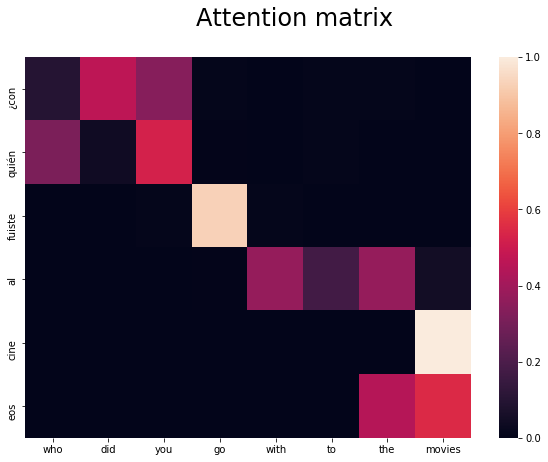

In [0]:
index = candidates[0][0].split()
columns = sentence.split()
df_cm = pd.DataFrame(attention_matrix[:len(index), -len(columns):], index=index, columns=columns)
fig = plt.figure(figsize=(10,7))
fig.suptitle('Attention matrix', fontsize=24)
sn.heatmap(df_cm)

### *Attention is all you need*

En 2017, Google publicó un artículo muy influente con el título provocador "[Attention is all you need](https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf)" o, sólo hace falta atención. Conseguieron muy buenos resultados, batiendo algunos records, sólo con atención y sin ninguna RNN (LSTM, GRU, etc) ni convolución. Una de las innovaciones clave fue un encoder de la posición de cada palabra ("[positional encoding](https://timodenk.com/blog/linear-relationships-in-the-transformers-positional-encoding/)"), lo que permite tratar frases enteras de manera global en lugar de palabra por palabra. El bloque de capas que constitue el encoder y el decoder se llama un [transformer](https://github.com/tensorflow/models/blob/master/official/transformer/model/transformer.py).

![texto alternativo](https://lilianweng.github.io/lil-log/assets/images/transformer.png)

https://www.tensorflow.org/beta/tutorials/text/transformer